# (논문) Chest X-ray
> kaggle_chest x-ray data를 활용한 CNN and CAM

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

---

### import 

In [228]:
import torch 
from fastai.vision.all import * 
import cv2 

In [2]:
import fastbook
from fastbook import *

In [3]:
from fastai.vision.widgets import *

### data

refer : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [4]:
path=Path('/home/khy/chest_xray/chest_xray') 

In [5]:
path.ls()

(#5) [Path('/home/khy/chest_xray/chest_xray/train'),Path('/home/khy/chest_xray/chest_xray/test'),Path('/home/khy/chest_xray/chest_xray/chest_xray'),Path('/home/khy/chest_xray/chest_xray/__MACOSX'),Path('/home/khy/chest_xray/chest_xray/val')]

In [6]:
files=get_image_files(path)

In [7]:
files

(#11712) [Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0766-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1318-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0160-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1327-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0489-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0509-0001-0002.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0761-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0416-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0566-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0411-0001.jpeg')...]

In [8]:
dls = ImageDataLoaders.from_folder(path, train='train', valid_pct=0.2, item_tfms=Resize(224))      

In [9]:
dls.vocab

['NORMAL', 'PNEUMONIA']

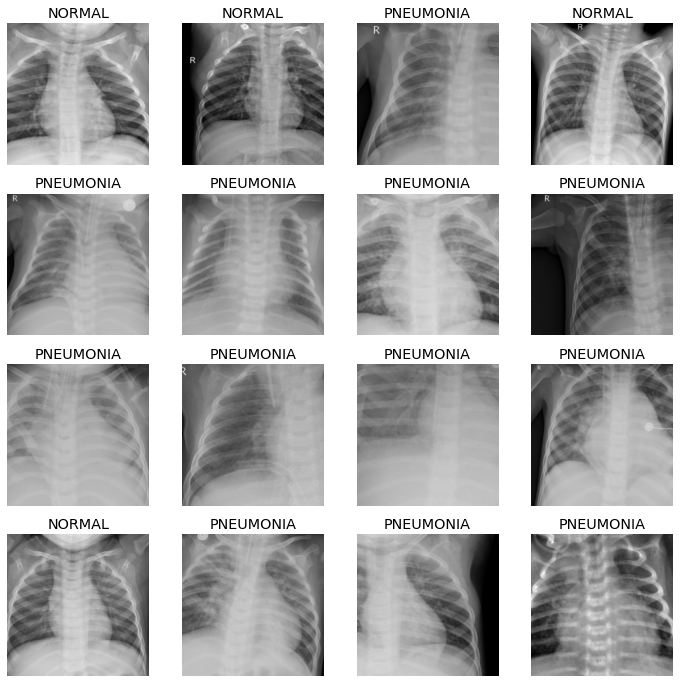

In [10]:
dls.show_batch(max_n=16)

In [11]:
learn=cnn_learner(dls,resnet34,metrics=error_rate)

In [12]:
net1=learn.model[0]
net2=learn.model[1] 

In [13]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [14]:
net=torch.nn.Sequential(net1,net2)

In [15]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [16]:
lrnr2.fine_tune(200) 

### CAM 결과 확인_에폭 200

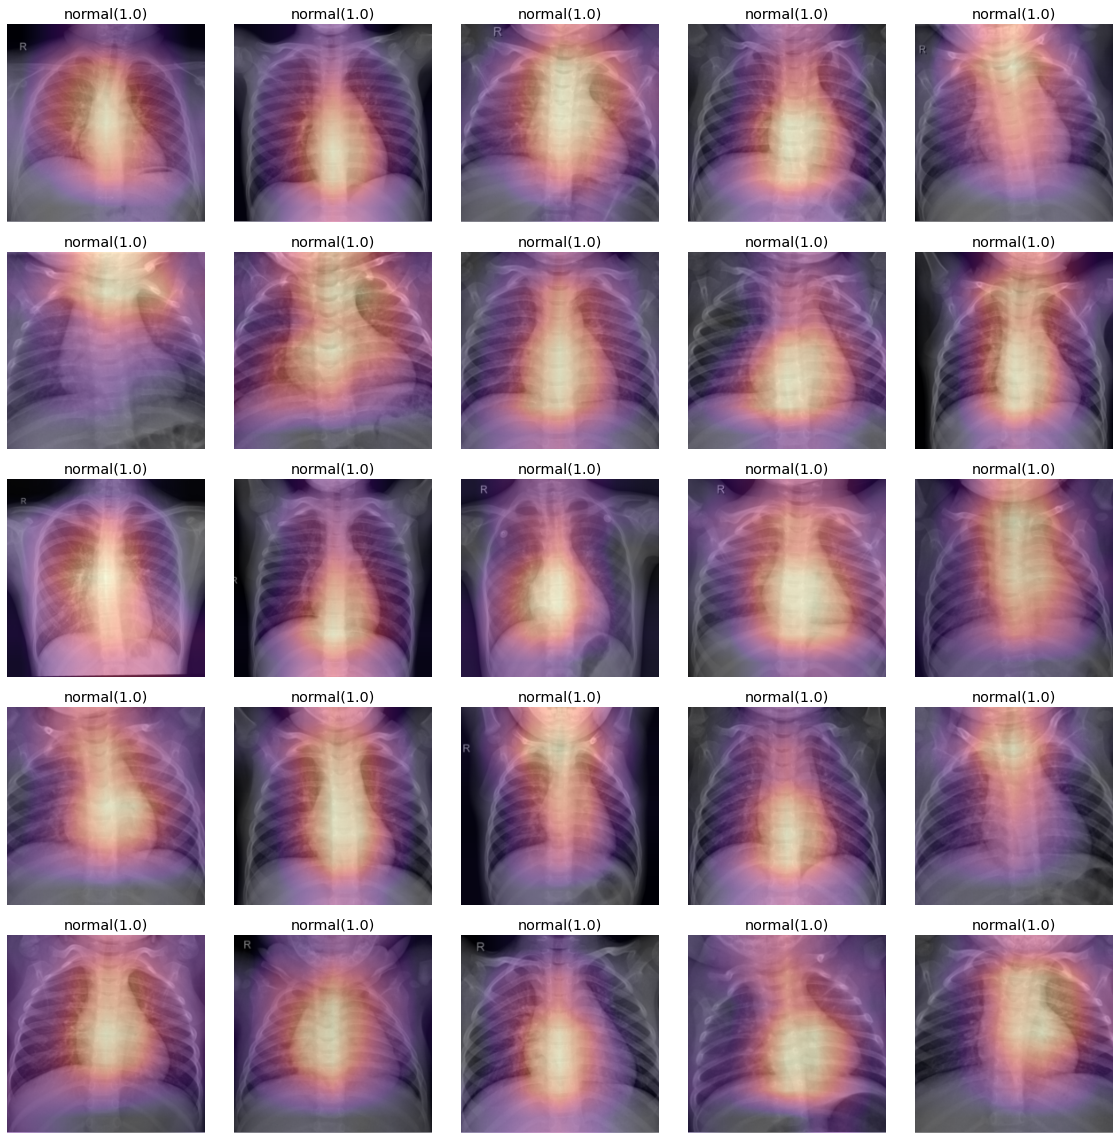

In [17]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        normalprob, pneumoniaprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if normalprob>pneumoniaprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("normal(%s)" % normalprob.round(5))
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("pneumonia(%s)" % pneumoniaprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

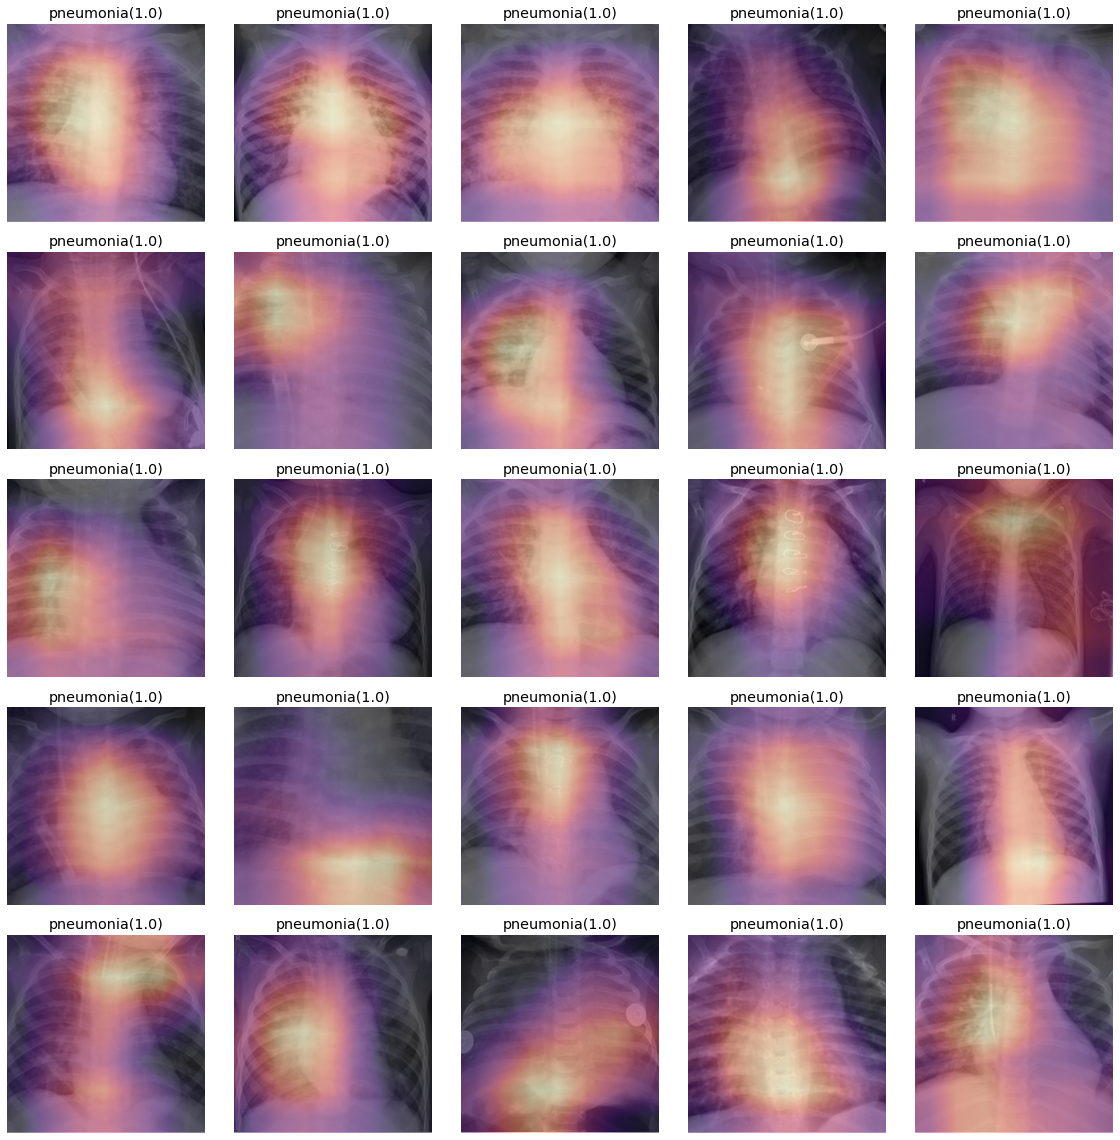

In [18]:
fig, ax = plt.subplots(5,5) 
k=3000 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        normalprob, pneumoniaprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if normalprob>pneumoniaprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("normal(%s)" % normalprob.round(5))
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("pneumonia(%s)" % pneumoniaprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

---

### SAMPLE

In [235]:
get_image_files(path)[3021]

Path('/home/khy/chest_xray/chest_xray/train/PNEUMONIA/person12_bacteria_47.jpeg')

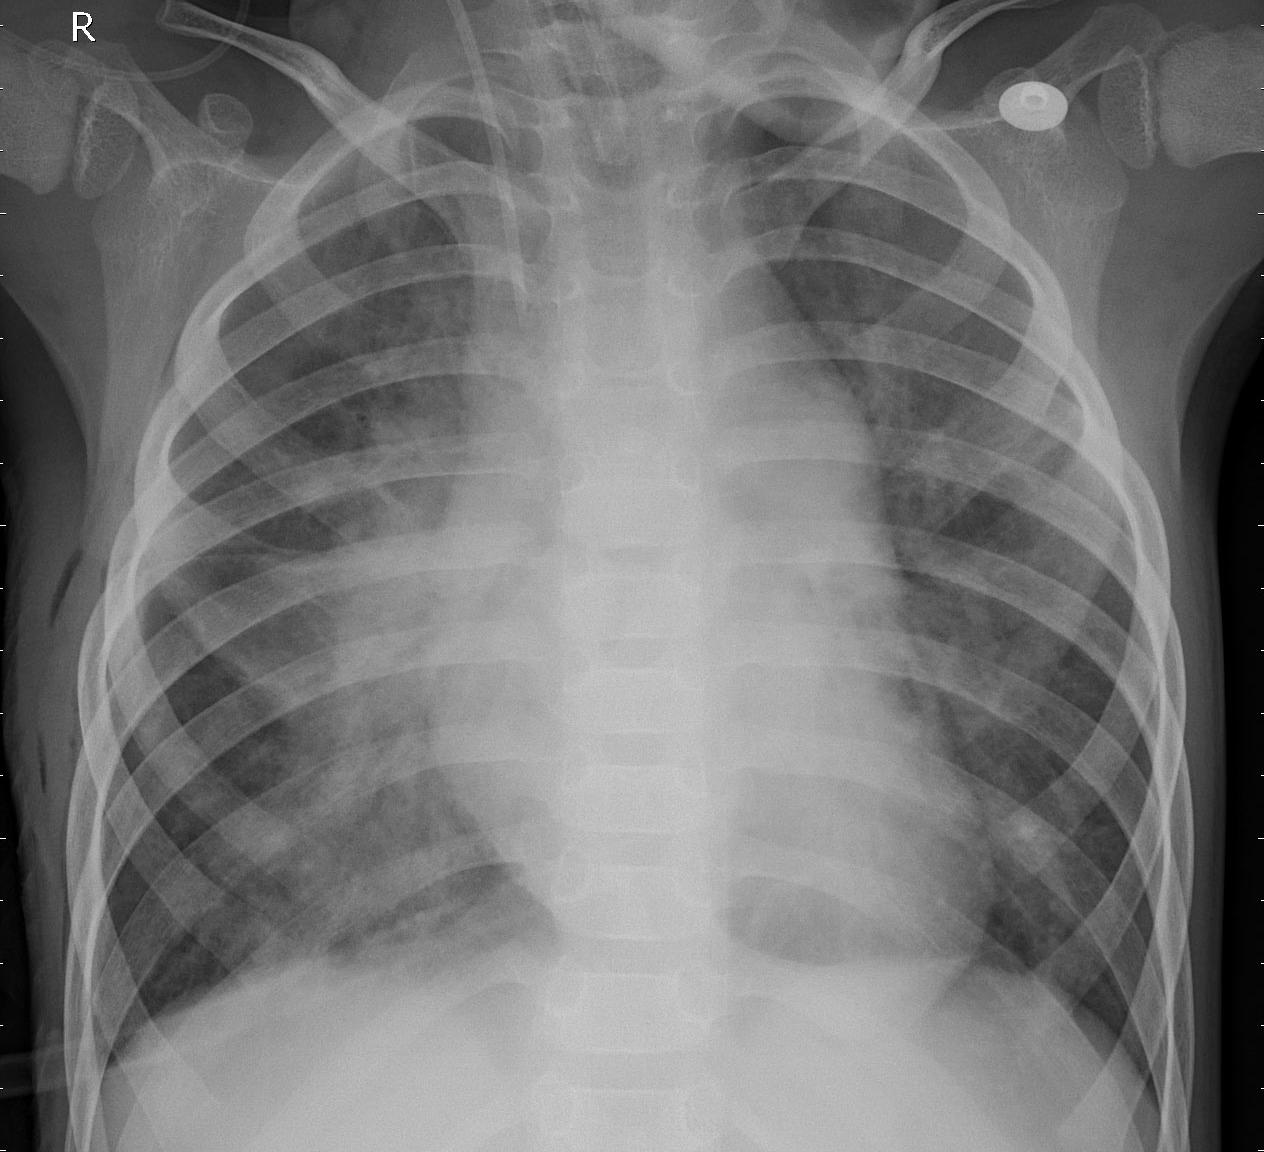

In [236]:
img = PILImage.create(get_image_files(path)[3021])
img

In [237]:
x, = first(dls.test_dl([img]))  #이미지 텐서화

In [238]:
x.shape

torch.Size([1, 3, 224, 224])

#### ★ **판단 근거가 강할수록 파란색 $\to$ 보라색 변함**

In [138]:
a=net(x.to('cpu')).tolist()[0][0]
b=net(x.to('cpu')).tolist()[0][1]
np.exp(a)/(np.exp(a)+np.exp(b)), np.exp(b)/(np.exp(a)+np.exp(b))

(1.0052419841905753e-22, 1.0)

In [239]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x.to('cpu')).squeeze())

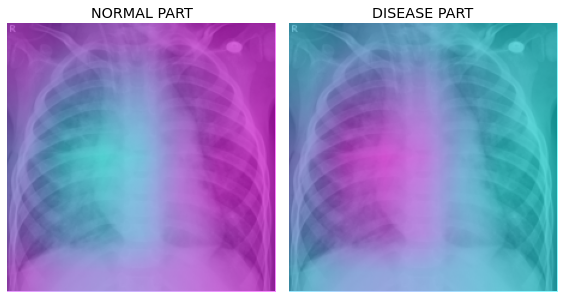

In [240]:
fig, (ax1,ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [241]:
test=camimg[1]-torch.min(camimg[1])

In [260]:
A1=torch.exp(-0.02*test)

In [261]:
A2=1-A1

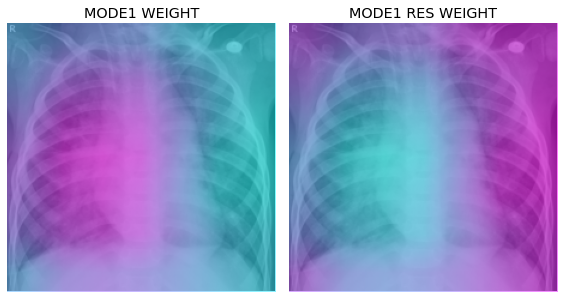

In [262]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE1 WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A1.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE1 RES WEIGHT")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [263]:
#mode1_res*x
X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
Y1=torch.Tensor(cv2.resize(X1,(224,224),interpolation=cv2.INTER_LINEAR))
x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)

In [264]:
#mode1*x
X12=np.array(A2.to("cpu").detach(),dtype=np.float32)
Y12=torch.Tensor(cv2.resize(X12,(224,224),interpolation=cv2.INTER_LINEAR))
x12=x.squeeze().to('cpu')*Y12#-torch.min(x.squeeze().to('cpu')*Y12)

- 1st CAM 결과를 분리하면 아래와 같음.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


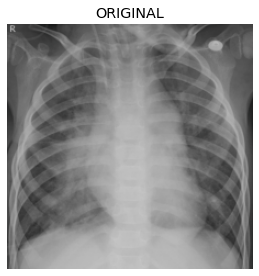

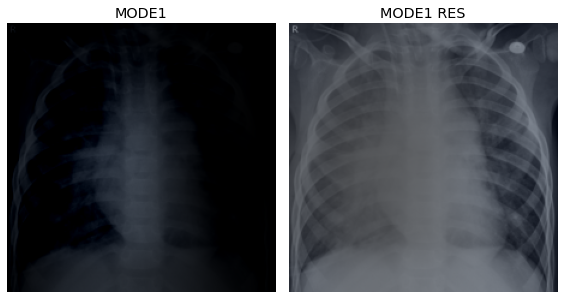

In [266]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12*0.3).squeeze().show(ax=ax1)  #MODE1
(x1*0.2).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [267]:
x1=x1.reshape(1,3,224,224)

In [268]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [269]:
camimg1 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

- CAM

    - mode1_res에 CAM 결과 올리기

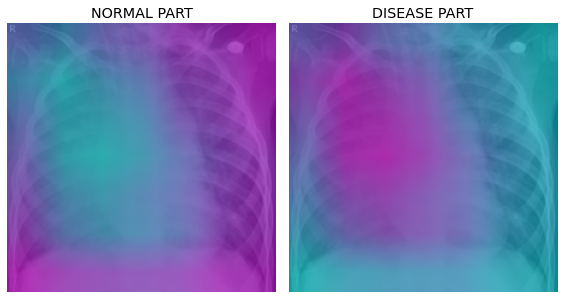

In [270]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
(x1*0.2).squeeze().show(ax=ax1)
ax1.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
(x1*0.2).squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

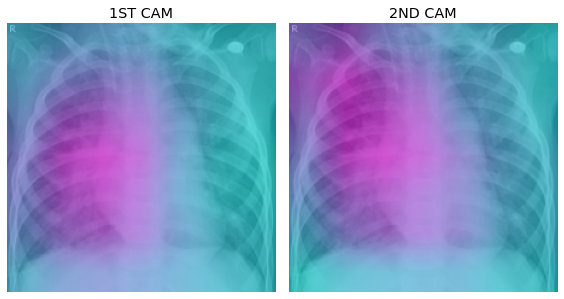

In [271]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [272]:
x1.shape

torch.Size([1, 3, 224, 224])

In [273]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

(1.7377578816154669e-12, 0.9999999999982623)

In [276]:
test1=camimg1[1]-torch.min(camimg1[1])

In [277]:
A3=torch.exp(-0.04*test1)  

In [278]:
A4=1-A3

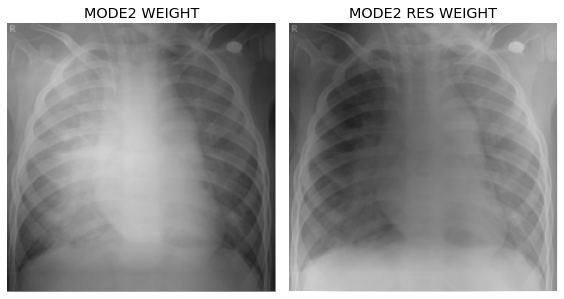

In [291]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A3.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='binary')
ax1.set_title("MODE2 WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='binary')
ax2.set_title("MODE2 RES WEIGHT")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [281]:
#mode2_res
X3=np.array(A3.to("cpu").detach(),dtype=np.float32)
Y3=torch.Tensor(cv2.resize(X3,(224,224),interpolation=cv2.INTER_LINEAR))
x3=x.squeeze().to('cpu')*Y1*Y3-torch.min(x.squeeze().to('cpu')*Y1*Y3)
#x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)

In [282]:
#mode2*x
X4=np.array(A4.to("cpu").detach(),dtype=np.float32)
Y4=torch.Tensor(cv2.resize(X4,(224,224),interpolation=cv2.INTER_LINEAR))
x4=x.squeeze().to('cpu')*Y12*Y4
#x12=x.squeeze().to('cpu')*Y12

- 2nd CAM 결과를 분리하면 아래와 같음.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


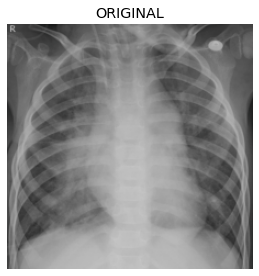

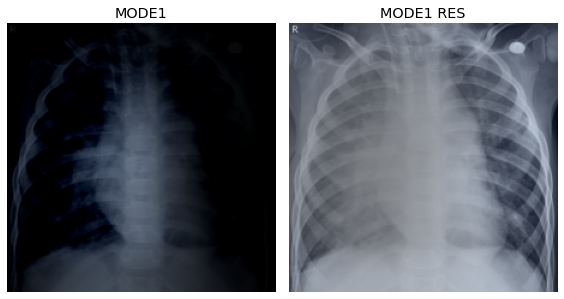

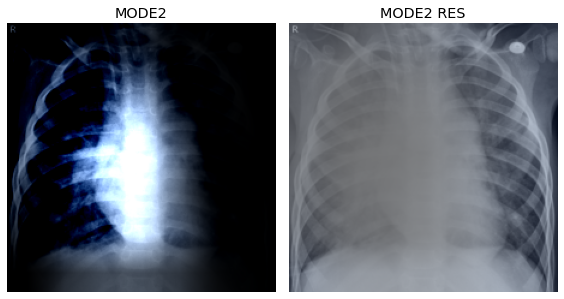

In [296]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12*0.5).squeeze().show(ax=ax1)  
(x1*0.3).squeeze().show(ax=ax2)  
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x4*3).squeeze().show(ax=ax1)  
(x3*0.3).squeeze().show(ax=ax2)  
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [297]:
x3=x3.reshape(1,3,224,224)

In [298]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [299]:
camimg2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x3).squeeze())

- CAM

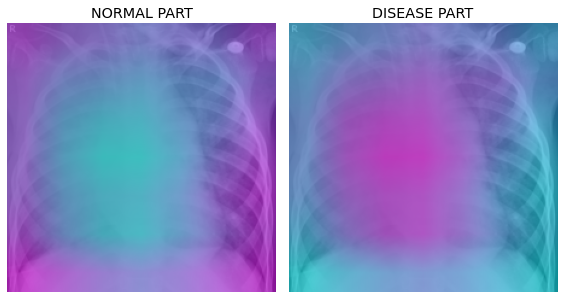

In [301]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
(x3*0.3).squeeze().show(ax=ax1)
ax1.imshow(camimg2[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
(x3*0.3).squeeze().show(ax=ax2)
ax2.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [302]:
a2=net(x3).tolist()[0][0]
b2=net(x3).tolist()[0][1]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))

(5.853030916370377e-16, 0.9999999999999994)